In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, feature_selection, linear_model, ensemble

plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
# Load Data
train_df = pd.read_csv('train.csv')

In [3]:
def split_data(train_df):
    #Select 70% for training and 30% for validation
    n = round(len(train_df.index)*.8)
    rows = np.random.choice(train_df.index.values, n)
    train = train_df.ix[rows]
    val = train_df.drop(rows)
    
    # Get the y values from the training and validataion data, drop Id and SalePrice columns
    y_train = train['SalePrice']
    X_train = train.drop(['Id', 'SalePrice'], axis=1)
    y_val = val['SalePrice']
    X_val = val.drop(['Id', 'SalePrice'], axis=1)
    
    return X_train, y_train, X_val, y_val

In [4]:
def feature_engineering(df):
    # Let's make a date...column
    date = {'year': df['YrSold'], 'month': df['MoSold'], 'day': [1] * df.shape[0]}
    df['DateSold'] = pd.to_datetime(date)
    df['DateSold'] = (df['DateSold'] - df['DateSold'].min())  / np.timedelta64(1,'D')
    
    # Some features are rankings of the same type
    rank_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

    df['ExterQual'] = df['ExterQual'].map(rank_dict)
    df['ExterCond'] = df['ExterCond'].map(rank_dict)
    df['BsmtQual'] = df['BsmtQual'].map(rank_dict).fillna(0)
    df['BsmtCond'] = df['BsmtCond'].map(rank_dict).fillna(0)
    df['HeatingQC'] = df['HeatingQC'].map(rank_dict).fillna(0)
    df['KitchenQual'] = df['KitchenQual'].map(rank_dict)
    df['FireplaceQu'] = df['FireplaceQu'].map(rank_dict).fillna(0)
    df['GarageQual'] = df['GarageQual'].map(rank_dict).fillna(0)
    df['GarageCond'] = df['GarageCond'].map(rank_dict).fillna(0)
    df['PoolQC'] = df['PoolQC'].map(rank_dict).fillna(0)
    
    # Then there are other features that are really rankings
    df['LotShape'] = df['LotShape'].map({'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3':3})
    df['Utilities'] = df['Utilities'].map({'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1})
    df['LandSlope'] = df['LandSlope'].map({'Gtl': 0, 'Mod': 1, 'Sev': 2})
    df['BsmtExposure'] = df['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1}).fillna(0)
    df['BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 
                                                               'LwQ': 2, 'Unf': 1}).fillna(0) 
    df['BsmtFinType2'] = df['BsmtFinType2'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 
                                                               'LwQ': 2, 'Unf': 1}).fillna(0)
    df['Functional'] = df['Functional'].map({'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4,
                                                          'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0})
    df['GarageFinish'] = df['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1}).fillna(0)
    df['Fence'] = df['Fence'].map({'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWv': 1}).fillna(0)
    
    # Fill in None if the NaN value actually means that feature is not present, otherwise the process function
    # will fill in 'U' for truly unknown values later
    df['Alley'] = df['Alley'].fillna('None')
    df['GarageType'] = df['GarageType'].fillna('None')
    df['MiscFeature'] = df['MiscFeature'].fillna('None')
    
    return df
    

In [5]:
def change_features(X_train, X_test):
    X_train = feature_engineering(X_train)
    X_test = feature_engineering(X_test)
    
    return X_train, X_test
    

In [6]:
def fill_data(X_train, X_test):   
    # Get lists of continuous and categorical column names
    cont = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
    cat = X_train.select_dtypes(include=['object']).columns.tolist()
    
    # Fill in all the categorical NaN values with 'U' for Unknown
    X_train[cat] = X_train[cat].fillna('U')
    X_test[cat] = X_test[cat].fillna('U')

    # Fill the missing continuous values with the median or a more meaningful value
    X_train[cont] = X_train[cont].fillna(X_train[cont].median())
    X_train['GarageYrBlt'] = X_train['GarageYrBlt'].fillna(X_train['GarageYrBlt'].min())

    # Note that we're filling in the test data with values from the training set
    X_test[cont] = X_test[cont].fillna(X_train[cont].median())
    X_test['GarageYrBlt'] = X_test['GarageYrBlt'].fillna(X_train['GarageYrBlt'].min())
    
    return X_train, X_test


In [7]:
def normalize_features(X_train, X_test):
    # Normalize continuous variables
    skewed = X_train.skew(axis=0, numeric_only=True)
    skewed = skewed[skewed > 1].index.tolist()
    
    nml = preprocessing.Normalizer()
    nml = nml.fit(X_train[skewed])
    
    X_train[skewed] = nml.transform(X_train[skewed])
    X_test[skewed] = nml.transform(X_test[skewed])
    
    return X_train, X_test


In [8]:
def scale_features(X_train, X_test):
    # Get lists of continuous and categorical column names
    cont = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
    
    # Now let's center and scale the continuous variables, fit scaler with training data
    scl = preprocessing.StandardScaler()
    scl = scl.fit(X_train[cont])

    X_train[cont] = scl.transform(X_train[cont])
    X_test[cont] = scl.transform(X_test[cont])
    
    return X_train, X_test


In [9]:
def cat_to_cont(X_train, X_test):
    # Make continuous variables into dummy variables
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    # The DataFrame needs to have the same columns as the training data
    diff = list(X_train.columns.difference(X_test.columns))
    X_test = X_test.reindex(columns=list(X_test.columns.values) + diff)
    diff2 = list(X_test.columns.difference(X_train.columns))
    X_test = X_test.drop(diff2, axis=1)
    X_test = X_test.fillna(0)
    
    return X_train, X_test
    

In [10]:
def normalize_dv(y_train, y_test):  
    # Well use the natural log of sale price for our new DV since linear regression assumes normality
    y_train = np.log(y_train)
    y_test = np.log(y_test)
    
    return y_train, y_test

In [11]:
def process_data(X_train, y_train, X_test, y_test, feat_eng=False, fill=True,
                 norm_f=False, scale_f=False, c_to_c=True, norm_dv=False):
    if feat_eng == True:
        X_train, X_test = change_features(X_train, X_test)
    
    if fill == True:
        X_train, X_test = fill_data(X_train, X_test)
        
    if norm_f == True:
        X_train, X_test = normalize_features(X_train, X_test)
    
    if scale_f == True:
        X_train, X_test = scale_features(X_train, X_test)
        
    if c_to_c == True:
        X_train, X_test = cat_to_cont(X_train, X_test)
        
    if norm_dv == True:
        y_train, y_test = normalize_dv(y_train, y_test)
    
    return X_train, y_train, X_test, y_test
    

In [12]:
# Split the data first so that we use the same sets for all models we're comparing
X_train_df, y_train_df, X_val_df, y_val_df = split_data(train_df)

In [13]:
X_train = X_train_df.copy()
y_train = y_train_df.copy()
X_val = X_val_df.copy()
y_val = y_val_df.copy()

# You can play with features here
X_train, y_train, X_val, y_val = process_data(X_train, y_train, X_val, y_val, 
                                              feat_eng=True, norm_f=True, scale_f=True, norm_dv=True)

In [14]:
# OLS linear regression is pretty bad for this problem, but elastic net does well

r = [.01, .25, .05, .1, .5, .7, .9, .95, .99, 1]

lm = linear_model.ElasticNetCV(l1_ratio=r)
lm.fit(X_train, y_train)
pred_y_train = lm.predict(X_train)
pred_y_val = lm.predict(X_val)

print('Training:')
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((pred_y_train - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(X_train, y_train))
print('')
print('Test:')
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((pred_y_val - y_val) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(X_val, y_val))

Training:
Mean squared error: 0.01
Variance score: 0.93

Test:
Mean squared error: 0.04
Variance score: 0.77


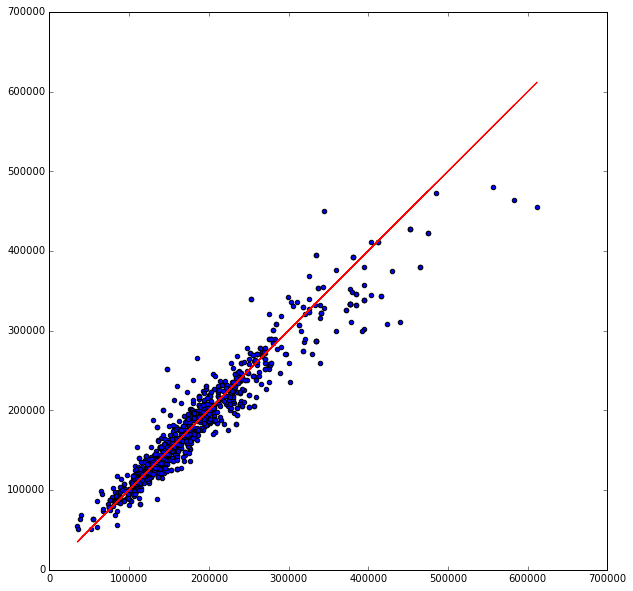

In [15]:
actual = np.exp(y_train)
predicted = np.exp(pred_y_train)
plt.scatter(actual, predicted)
plt.plot(actual, actual, 'r')

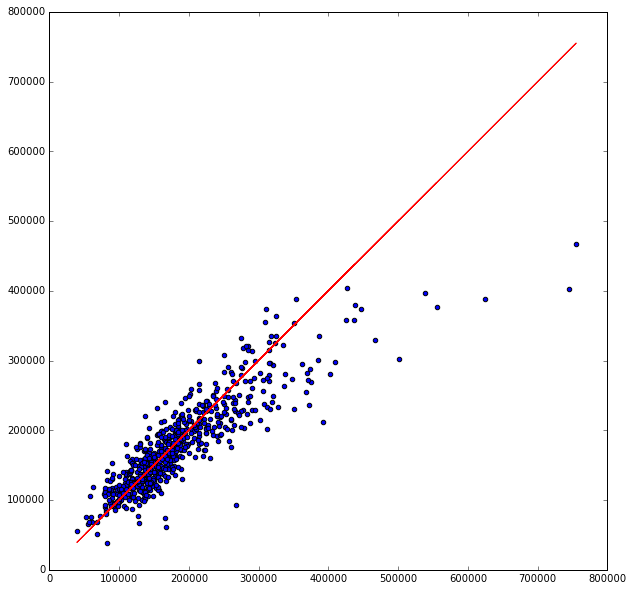

In [16]:
actual = np.exp(y_val)
predicted = np.exp(pred_y_val)
plt.scatter(actual, predicted)
plt.plot(actual, actual, 'r')

In [17]:
def model(X_train, y_train, X_val, y_val, m):
    m.fit(X_train, y_train)
    pred_y_train = m.predict(X_train)
    pred_y_val = m.predict(X_val)

    print('Training:')
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((pred_y_train - y_train) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % m.score(X_train, y_train))
    print('')
    print('Test:')
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((pred_y_val - y_val) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % m.score(X_val, y_val))
    
    actual = np.exp(y_val)
    predicted = np.exp(pred_y_val)
    plt.scatter(actual, predicted)
    plt.plot(actual, actual, 'r')
    plt.show()
    
    try:
        feature_importance = m.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        plt.figure(figsize=(8,50))
        plt.subplot(1, 2, 2)
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('Variable Importance')
        plt.show()
    except:
        pass
    

Training:
Mean squared error: 0.01
Variance score: 0.94

Test:
Mean squared error: 733549267652696735744.00
Variance score: -4451930080572299280384.00


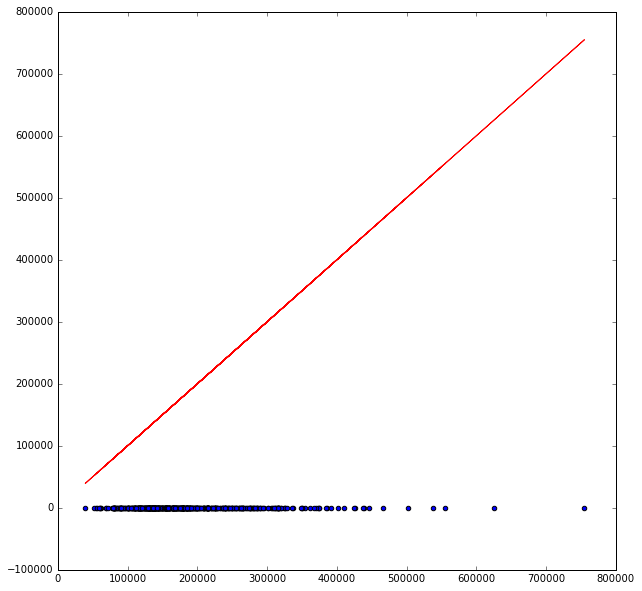

In [18]:
m = linear_model.LinearRegression()
model(X_train, y_train, X_val, y_val, m)

Training:
Mean squared error: 0.01
Variance score: 0.93

Test:
Mean squared error: 0.04
Variance score: 0.77


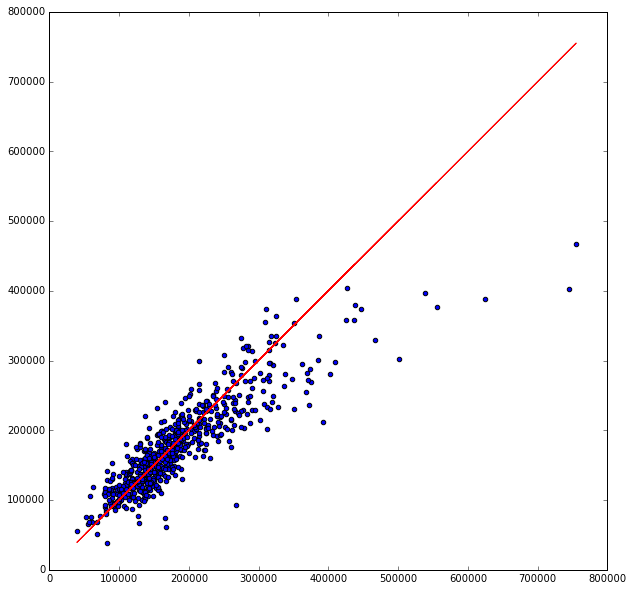

In [19]:
m = linear_model.LassoCV()
model(X_train, y_train, X_val, y_val, m)

Training:
Mean squared error: 0.00
Variance score: 0.99

Test:
Mean squared error: 0.03
Variance score: 0.83


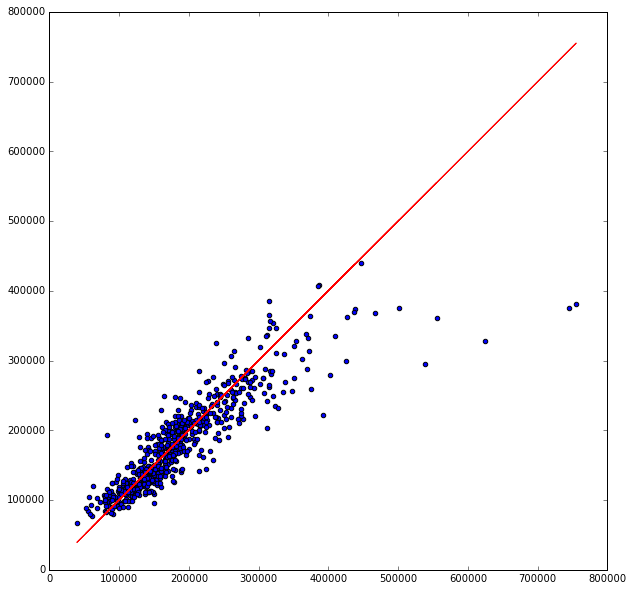

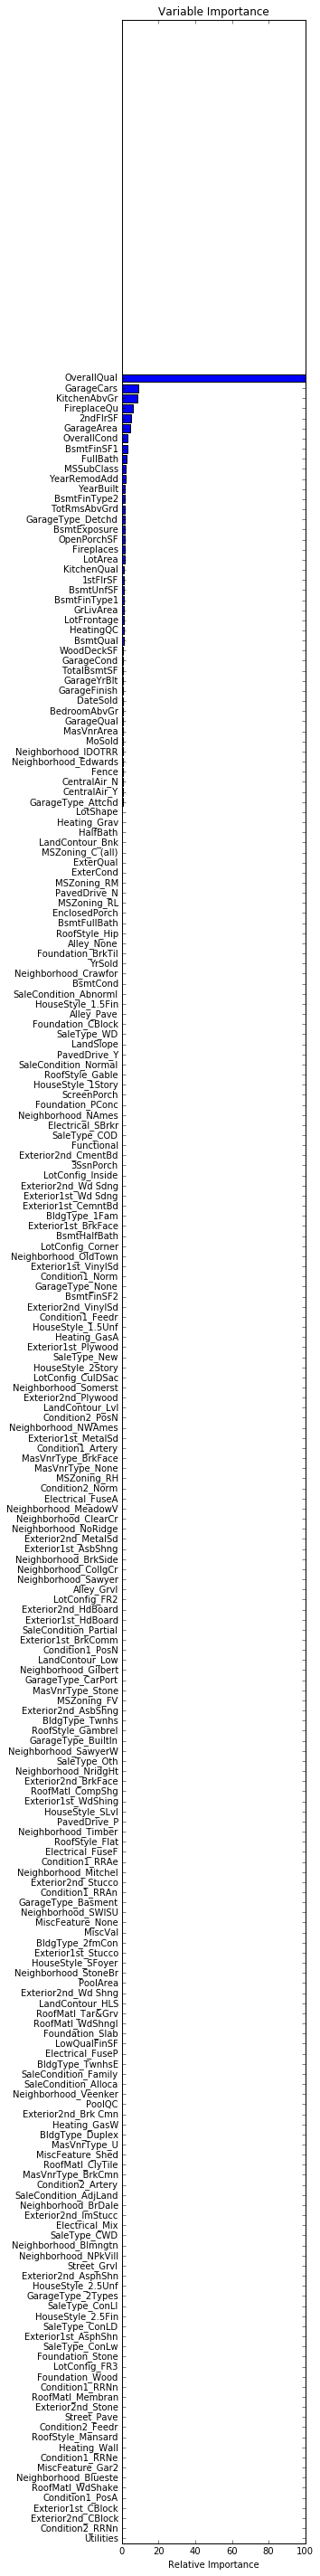

In [20]:
m = ensemble.RandomForestRegressor(n_estimators=200)
model(X_train, y_train, X_val, y_val, m)

Training:
Mean squared error: 0.00
Variance score: 1.00

Test:
Mean squared error: 0.02
Variance score: 0.85


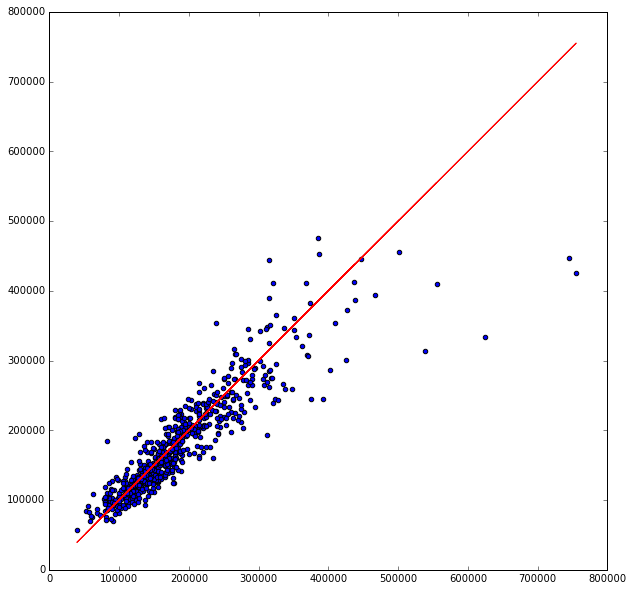

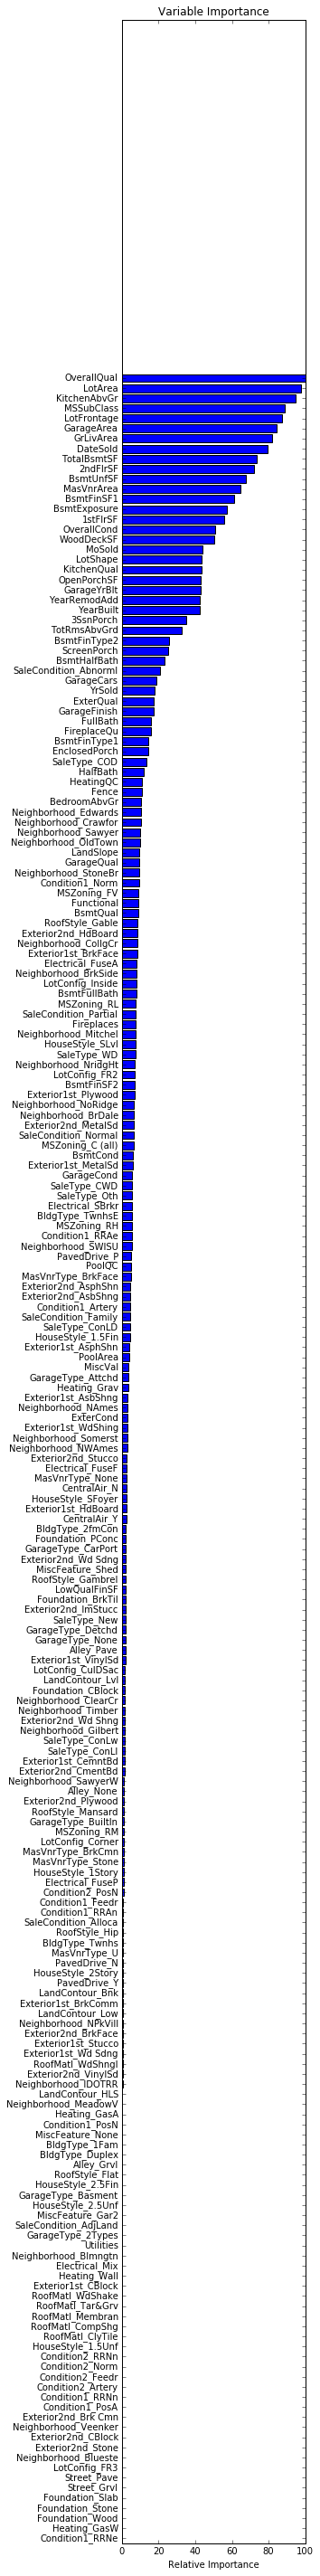

In [21]:
m = ensemble.GradientBoostingRegressor(n_estimators=200, max_depth=5)
model(X_train, y_train, X_val, y_val, m)

Training:
Mean squared error: 0.00
Variance score: 0.97

Test:
Mean squared error: 0.03
Variance score: 0.83


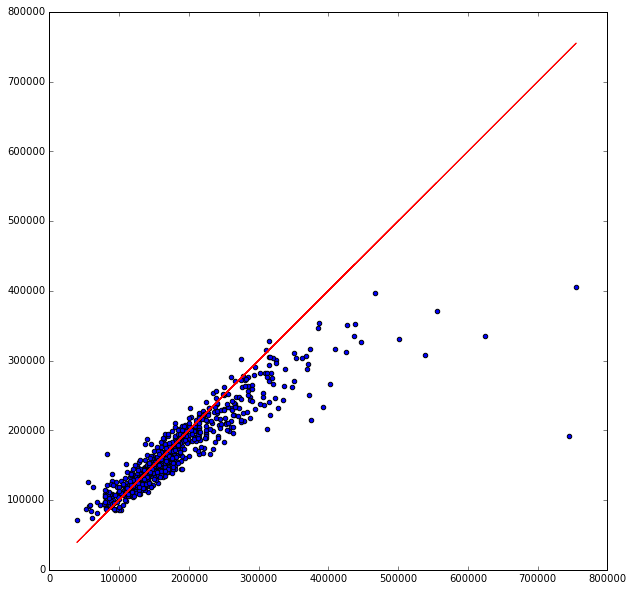

In [22]:
from sklearn import svm
m = svm.SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=2.0, 
            epsilon=0.04, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model(X_train, y_train, X_val, y_val, m)

0.03374568522923949


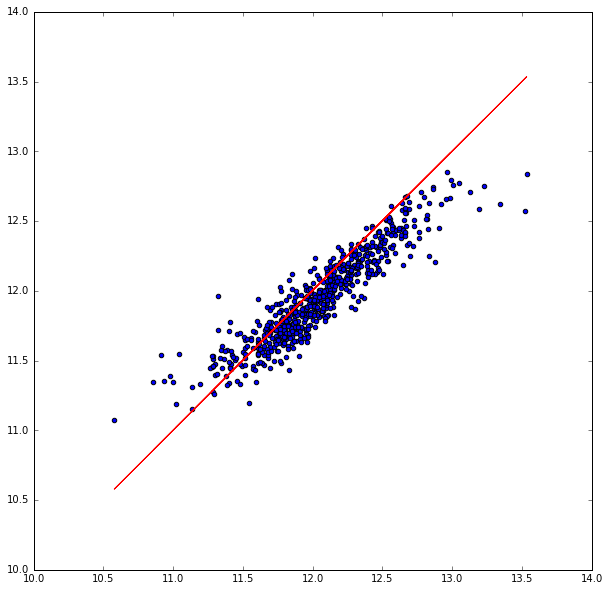

In [23]:
m = ensemble.GradientBoostingRegressor()
m.fit(X_train, y_train)
p1 = m.predict(X_val)
m = svm.SVR()
m.fit(X_train, y_train)
p2 = m.predict(X_val)

avg_pred = (p1 + p2)/2
print(np.mean((avg_pred - y_val) ** 2))

actual = y_val
predicted = avg_pred
plt.scatter(actual, predicted)
plt.plot(actual, actual, 'r')
plt.show()

    

In [24]:
c = train_df.corr().abs()
train_df.shape

(1460, 81)

In [25]:
s = c.unstack()
so = s.sort_values()

print(so[-77:-37:2])

YearBuilt     YearRemodAdd    0.592855
GrLivArea     OverallQual     0.593007
OverallQual   GarageCars      0.600671
1stFlrSF      SalePrice       0.605852
HalfBath      2ndFlrSF        0.609707
SalePrice     TotalBsmtSF     0.613581
2ndFlrSF      TotRmsAbvGrd    0.616423
SalePrice     GarageArea      0.623431
FullBath      GrLivArea       0.630012
SalePrice     GarageCars      0.640409
GarageYrBlt   YearRemodAdd    0.642277
BsmtFullBath  BsmtFinSF1      0.649212
BedroomAbvGr  TotRmsAbvGrd    0.676620
2ndFlrSF      GrLivArea       0.687501
GrLivArea     SalePrice       0.708624
OverallQual   SalePrice       0.790982
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
GarageYrBlt   YearBuilt       0.825667
GarageCars    GarageArea      0.882475
dtype: float64


In [26]:
# Let's do an f test

f_test = feature_selection.f_regression(X_train, y_train)
f_test_df = pd.DataFrame(list(zip(X_train.columns.values, np.round(f_test[0], 2), 
                                np.round(f_test[1], 4))), columns=['Features', 'F', 'p'])
f_test_df

,Features,F,p
0,MSSubClass,65.74,0.0000
1,LotFrontage,85.06,0.0000
2,LotArea,5.55,0.0186
3,LotShape,37.04,0.0000
4,Utilities,NaN,NaN
5,LandSlope,0.57,0.4495
6,OverallQual,2096.55,0.0000
7,OverallCond,1.60,0.2064
8,YearBuilt,567.96,0.0000
9,YearRemodAdd,491.01,0.0000


In [27]:
# Get a list of best features, here defined as ones with F > 1000 (totally arbitrary) 
mask = f_test_df['F'] > 1000
best = f_test_df[mask]['Features'].tolist()
best

['OverallQual', 'KitchenQual']

In [28]:
# What happens if we only use a few features?
# In that case OLS linear regression is fine and not any worse than other models

f = ['OverallQual', 'GarageCars']

lm = linear_model.LinearRegression()
lm.fit(X_train[f], y_train)
pred_y_train = lm.predict(X_train[f])
pred_y_val = lm.predict(X_val[f])

print('Training:')
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((pred_y_train - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(X_train[f], y_train))
print('')
print('Test:')
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((pred_y_val - y_val) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lm.score(X_val[f], y_val))

Training:
Mean squared error: 0.04
Variance score: 0.70

Test:
Mean squared error: 0.04
Variance score: 0.74


In [29]:
def mse(X_train, y_train, X_val, y_val, m):
    m.fit(X_train, y_train)
    pred_y_val = m.predict(X_val)
    mse_val = (pred_y_val - y_val) ** 2
    return mse_val

def avg_mse(data, n):
    
    mse_en = []
    mse_rf = []
    mse_gb = []
    mse_svr = []
    
    for i in range(n):
        X_train, y_train, X_val, y_val = split_data(data)
        X_train = X_train_df.copy()
        y_train = y_train_df.copy()
        X_val = X_val_df.copy()
        y_val = y_val_df.copy()
        X_train, y_train, X_val, y_val = process_data(X_train, y_train, X_val, y_val, 
                                                      feat_eng=True, norm_f=True, scale_f=True, norm_dv=True)
        m1 = linear_model.ElasticNetCV()
        mse_val = mse(X_train, y_train, X_val, y_val, m1)
        mse_en.append(mse_val)
        m2 = ensemble.RandomForestRegressor(n_estimators=200)
        mse_val = mse(X_train, y_train, X_val, y_val, m2)
        mse_rf.append(mse_val)
        m3 = ensemble.GradientBoostingRegressor(n_estimators=200, max_depth=5)
        mse_val = mse(X_train, y_train, X_val, y_val, m3)
        mse_gb.append(mse_val)
        m4 = svm.SVR(epsilon=0.04)
        mse_val = mse(X_train, y_train, X_val, y_val, m4)
        mse_svr.append(mse_val)
      
    print('Elactic Net:', round(np.mean(mse_en), 4))
    print('Random Forest:', round(np.mean(mse_rf), 4))
    print('Gradient Boosting:', round(np.mean(mse_gb), 4))
    print('Support Vector:', round(np.mean(mse_svr), 4))
            

In [32]:
avg_mse(train_df, 50)

Elactic Net: 0.0346
Random Forest: 0.0278
Gradient Boosting: 0.024
Support Vector: 0.0253
